**TODO:**
- [x] Build NTEE-10 major groups.
- [x] Vectorize output labels.
- [x] Vectorize input texts.
- [x] Spell check.
- [x] Resampling - Add more records of 'VI' (International, Foreign Affairs - Q).
- [x] Grid search. - Not feasible, need too much resources (i.e., memory, CPU).
- [x] Spellcheck.
- [x] Train/test dataset complete split.
- [ ] Solve reproducibility problem, [Ref1](https://github.com/keras-team/keras/issues/7676) [Ref2](https://github.com/keras-team/keras/issues/4875) [Ref3 (solution)](https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)

In [1]:
# obtain reproducible results

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Rest of code follows ...

# Check GPU device.
print(K.tensorflow_backend._get_available_gpus())

[]


Using TensorFlow backend.


In [6]:
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#RNN

import os
import pandas as pd
import re
from tqdm import tqdm
from multiprocessing import Pool
from spellchecker import SpellChecker
import string
import math

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from nltk import word_tokenize

# For encoding labels.
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

## Read and compile tranining and validation dataset.

In [17]:
train_file_path='../../dataset/UCF/train/'
file_list=os.listdir(train_file_path)
df_train=pd.DataFrame()
for file in file_list:
    df_train=pd.concat([df_train, pd.read_pickle(train_file_path+file, compression='gzip')])

test_file_path='../../dataset/UCF/test/'
file_list=os.listdir(test_file_path)
df_test=pd.DataFrame()
for file in file_list:
    df_test=pd.concat([df_test, pd.read_pickle(test_file_path+file, compression='gzip')])
    
len(df_train), len(df_test)

(154424, 38607)

In [19]:
df_train.head()

,DLN,EIN,FILING_TYPE,IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt,IRS990EZ_p3_PrmryExmptPrpsTxt,IRS990PF_p16b_RltnshpSttmntTxt,IRS990PF_p9a_DscrptnTxt,IRS990ScheduleO_ExplntnTxt,IRS990_p1_ActvtyOrMssnDsc,IRS990_p3_DscS,...,SUB_DATE,TAXPAYER_NAME,TAX_PERIOD,YEAR,95_and_before,NTEE1,mission,prgrm_dsc,mission_spellchk,prgrm_dsc_spellchk
1363470,9.349332e+13,390768547,EFILE,NaN,NaN,NaN,NaN,,TO PROVIDE A MEMBERSHIP ORGANIZATION FOR THE M...,PARADE OF HOMES - ANNUAL SHOW EXHIBITING THE L...,...,12/31/2014,MADISON AREA BUILDERS ASSOCIATION INC,201312.0,2014.0,1.0,S,TO PROVIDE A MEMBERSHIP ORGANIZATION FOR THE M...,DREAM HOME SHOWCASE - ANNUAL SHOW TO PROVIDE B...,TO PROVIDE A MEMBERSHIP ORGANIZATION FOR THE M...,DREAM HOME SHOWCASE - ANNUAL SHOW TO PROVIDE B...
424991,9.349331e+13,943309195,EFILE,NaN,NaN,NaN,NaN,,TO IMPROVE THE DENTAL HEALTH OF CHILDREN IN NE...,"DENTAL HEALTH EDUCATION, PREVENTION, DETECTION...",...,02/03/2016,PRASAD CHILDRENS DENTAL HEALTH PROGRAM INC,201412.0,2016.0,0.0,E,TO IMPROVE THE DENTAL HEALTH OF CHILDREN IN NE...,"DENTAL HEALTH EDUCATION, PREVENTION, DETECTION...",TO IMPROVE THE DENTAL HEALTH OF CHILDREN IN NE...,"DENTAL HEALTH EDUCATION , PREVENTION , DETECTI..."
1816561,9.349226e+13,262616556,EFILE,ROTARY FOUNDATION,COMMUNITY AND WORLDWIDE OUTREACH.,NaN,NaN,,NaN,NaN,...,10/29/2014 8:28:06 AM,ROTARY CLUB OF MILTON-WINDWARD FOUNDATION INCO...,201312.0,2014.0,0.0,S,COMMUNITY AND WORLDWIDE OUTREACH.,ROTARY FOUNDATION,COMMUNITY AND WORLDWIDE OUTREACH .,ROTARY FOUNDATION
1558658,9.349313e+13,410646500,EFILE,NaN,NaN,NaN,NaN,,Provided social recreational activities for th...,Provided social-recreational activities for al...,...,7/16/2015,AMERICAN LEGION POST 241,201406.0,2015.0,1.0,W,PROVIDED SOCIAL RECREATIONAL ACTIVITIES FOR TH...,PROVIDED SOCIAL-RECREATIONAL ACTIVITIES FOR AL...,PROVIDED SOCIAL RECREATIONAL ACTIVITIES FOR TH...,PROVIDED SOCIAL-RECREATIONAL ACTIVITIES FOR AL...
1781284,9.349323e+13,60646844,EFILE,NaN,NaN,NaN,NaN,INPATIENT SERVICES SAINT MARY'S REMAINS COMMIT...,SAINT MARY'S HOSPITAL PROVIDES EXCELLENT HEALT...,INPATIENT SAINT MARY'S REMAINS COMMITTED TO PR...,...,10/5/2015,ST MARYS HOSPITAL INC,201409.0,2015.0,1.0,E,SAINT MARY'S HOSPITAL PROVIDES EXCELLENT HEALT...,INPATIENT SAINT MARY'S REMAINS COMMITTED TO PR...,SAINT MARY IS HOSPITAL PROVIDES EXCELLENT HEAL...,INPATIENT SAINT MARY IS REMAINS COMMITTED TO P...


I. Arts, Culture, and Humanities - A  
II. Education - B  
III. Environment and Animals - C, D  
IV. Health - E, F, G, H  
V. Human Services - I, J, K, L, M, N, O, P  
VI. International, Foreign Affairs - Q  
VII. Public, Societal Benefit - R, S, T, U, V, W  
VIII. Religion Related - X  
IX. Mutual/Membership Benefit - Y  
X. Unknown, Unclassified - Z  

In [20]:
# Code as 10 broad categories.
broad_cat_dict={'I': ['A'],
                'II': ['B'],
                'III': ['C', 'D'],
                'IV': ['E', 'F', 'G', 'H'],
                'V': ['I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'],
                'VI': ['Q'],
                'VII': ['R', 'S', 'T', 'U', 'V', 'W'],
                'VIII': ['X'],
                'IX': ['Y'],
                'X': ['Z'],
               }
def ntee2cat(string):
    global broad_cat_dict
    return [s for s in broad_cat_dict.keys() if string in broad_cat_dict[s]][0]

df_train['mission_prgrm_spellchk']=df_train['TAXPAYER_NAME']+' '+df_train['mission_spellchk']+' '+df_train['prgrm_dsc_spellchk'] # Using spell-checked.
df_train['broad_cat']=df_train['NTEE1'].apply(ntee2cat)
print(len(df_train['mission_prgrm_spellchk']), len(df_train['NTEE1'].drop_duplicates()), len(df_train['broad_cat'].drop_duplicates()))

df_test['mission_prgrm_spellchk']=df_test['TAXPAYER_NAME']+' '+df_test['mission_spellchk']+' '+df_test['prgrm_dsc_spellchk'] # Using spell-checked.
df_test['broad_cat']=df_test['NTEE1'].apply(ntee2cat)
print(len(df_test['mission_prgrm_spellchk']), len(df_test['NTEE1'].drop_duplicates()), len(df_test['broad_cat'].drop_duplicates()))

154424 25 9
38607 25 9


In [22]:
df_train['mission_prgrm_spellchk'][:10]

1363470    MADISON AREA BUILDERS ASSOCIATION INC TO PROVI...
424991     PRASAD CHILDRENS DENTAL HEALTH PROGRAM INC TO ...
1816561    ROTARY CLUB OF MILTON-WINDWARD FOUNDATION INCO...
1558658    AMERICAN LEGION POST 241 PROVIDED SOCIAL RECRE...
1781284    ST MARYS HOSPITAL INC SAINT MARY IS HOSPITAL P...
2202860    NORTHERN ARIZONA VOLUNTEER MEDICAL AND SURGICA...
297296     BEL CANTO COMPANY INC TO PROVIDE CHORAL SINGIN...
394101     UNIVERSITY OF THE ANDES FOUNDATION INC THE PRI...
141481     CCBC PROPERTIES INC TO OWN , LEASE , AND MANAG...
1552925    SHAKEN BABY PREVENTION OF IDAHO INC TO BRING E...
Name: mission_prgrm_spellchk, dtype: object

<s>

```Python
# Build training and testing data frame.
small_num=0
while small_num<500: # Make sure each category has at least 500 records.
    sampleDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(120000)
    trainDF, valDF =train_test_split(sampleDF, test_size=.3)
    small_num=trainDF.groupby('NTEE_M').count().sort_values('EIN').iloc[0]['EIN']
```

</s>

In [23]:
# See the composition by NTEE major groups.
print(df_train.groupby('broad_cat').count()['EIN']/len(df_train), '\n'*2, df_test.groupby('broad_cat').count()['EIN']/len(df_test))

broad_cat
I       0.110151
II      0.167247
III     0.048969
IV      0.109025
IX      0.042998
V       0.302634
VI      0.012867
VII     0.176540
VIII    0.029568
Name: EIN, dtype: float64 

 broad_cat
I       0.111146
II      0.166265
III     0.048204
IV      0.112130
IX      0.044059
V       0.303650
VI      0.011293
VII     0.174813
VIII    0.028440
Name: EIN, dtype: float64


### Prepare labels.
*One hot encoding.* Prepare after resampling; otherwise, shape of `y_train` will shrink from 25 to 3.

In [24]:
df_train['broad_cat'][:10]

1363470    VII
424991      IV
1816561    VII
1558658    VII
1781284     IV
2202860     IV
297296       I
394101      II
141481      IV
1552925      V
Name: broad_cat, dtype: object

In [26]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(list(df_train.broad_cat.unique()))

y_train=lb.transform(df_train['broad_cat'])
# y_test=lb.transform(df_test['broad_cat']) # No need to transform Y for testing.

In [11]:
import pickle
# Save LabelBinarizer class for developing package.
with open('../../output/lb_broad_cat.pkl', 'wb') as output:
    pickle.dump(lb, output, pickle.HIGHEST_PROTOCOL)

_Not efficient codes, ignore._

<s>
    
``` Python
def one_hot(label_list, class_list):
    int_encoder=LabelEncoder().fit(class_list) # Build the encoder.
    label_int_encoded=int_encoder.transform(label_list) # One-dimensional integer encoded.
    return np_utils.to_categorical(label_int_encoded) # Multi-dimensional binary/one-hot encoded.

y_train=one_hot(label_list=df_train['NTEE1'], class_list=list(df_train.NTEE1.unique()))
y_test=one_hot(label_list=df_test['NTEE1'], class_list=list(df_train.NTEE1.unique()))
```

### One-dimensional integer encoding for grid search.

```Python
def int_encode(label_list, class_list):
    int_encoder=LabelEncoder().fit(class_list) # Build the encoder.
    label_int_encoded=int_encoder.transform(label_list) # One-dimensional integer encoded.
    return label_int_encoded # Multi-dimensional binary/one-hot encoded.

y_train=int_encode(label_list=trainDF['NTEE_M'], class_list=list(major_group_dict.keys()))
y_val=int_encode(label_list=valDF['NTEE_M'], class_list=list(major_group_dict.keys()))

# Use integer encoding: https://github.com/keras-team/keras/issues/9331
# Use sparse_categorical_crossentropy: https://keras.io/losses/
```
    
</s>

### Prepare input text.

**Wrong codes, stop words not removed because capitalizations are not consistent**
- If choose word embedding, no difference if not removed. 
- See reference: https://stackoverflow.com/questions/34721984/stopword-removing-when-using-the-word2vec/40447086#40447086

<s>
    
```Python
stop_list=stopwords.words('english')+list(string.punctuation)
def stopwords_remove(string):
    global stop_list
    tokens=word_tokenize(string)
    return [s for s in tokens if s not in stop_list]

text_token_list_train=df_train['mission_prgrm_spellchk'].apply(stopwords_remove)
text_token_list_test=df_test['mission_prgrm_spellchk'].apply(stopwords_remove)
```
</s>

In [12]:
text_token_list_train=df_train['mission_prgrm_spellchk']
text_token_list_test=df_test['mission_prgrm_spellchk']

**Moved to preprocessing pipeline.**

<s>

```Python
# Spell check function. Return corrected word if unknown; return original word if known.
def spellcheck(word_string_list):
    return [SpellChecker().correction(word=s).upper() for s in word_string_list]

# Parallel computing
p = Pool(48)
text_token_list_train=p.map(spellcheck, text_token_list_train)
text_token_list_val=p.map(spellcheck, text_token_list_val)
# Pool.map keep the original order of data passed to map.
# https://stackoverflow.com/questions/41273960/python-3-does-pool-keep-the-original-order-of-data-passed-to-map
```

</s>

In [13]:
# Build word index for train and validation texts.
tokenizer=Tokenizer()
tokenizer.fit_on_texts(text_token_list_train.to_list()+text_token_list_test.to_list())
print(list(tokenizer.word_index.items())[0:5])

[('and', 1), ('the', 2), ('to', 3), ('of', 4), ('in', 5)]


In [14]:
import pickle
# Save tokenizer class for developing package.
with open('../../output/tokenizer.pkl', 'wb') as output:
    pickle.dump(tokenizer, output, pickle.HIGHEST_PROTOCOL)

In [15]:
# Text to sequences.
seq_encoding_text_train=tokenizer.texts_to_sequences(text_token_list_train)
seq_encoding_text_test=tokenizer.texts_to_sequences(text_token_list_test)

# Pads sequences to the same length (i.e., prepare matrix).
x_train=pad_sequences(sequences=seq_encoding_text_train,
                      maxlen=max([len(s) for s in seq_encoding_text_train]), # Max length of the sequence.
                      dtype = "int32", padding = "post", truncating = "post", 
                      value = 0 # Zero is used for representing None or Unknown.
                     )

x_test=pad_sequences(sequences=seq_encoding_text_test,
                    maxlen=max([len(s) for s in seq_encoding_text_train]), # Max length of the sequence.
                    dtype = "int32", padding = "post", truncating = "post", 
                    value = 0 # Zero is used for representing None or Unknown.
                     )

In [16]:
x_train[:10]

array([[ 2226,    64,  2561, ...,     0,     0,     0],
       [33293,   942,   442, ...,     0,     0,     0],
       [  354,    69,     4, ...,     0,     0,     0],
       ...,
       [  132,     4,     2, ...,     0,     0,     0],
       [67880,  1274,    18, ...,     0,     0,     0],
       [21742,  2036,   283, ...,     0,     0,     0]], dtype=int32)

### Resample.

In [12]:
# # Convert to Compressed Sparse Row matrix; otherwise, matrix too large, result memory error.
# # https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
# from scipy.sparse import csr_matrix
# x_train=csr_matrix(x_train)

# # Define resample strategy.
# def func_resample(method, sampling_strategy, x_train_vect, y_train):
#     if method=='ADASYN':
#         from imblearn.over_sampling import ADASYN
#         resample = ADASYN(sampling_strategy=sampling_strategy, random_state=42)
#     elif method=='RandomOverSampler':
#         from imblearn.over_sampling import RandomOverSampler
#         resample = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
#     elif method=='SMOTE':
#         from imblearn.over_sampling import SMOTE
#         resample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
#     elif method=='SMOTEENN':
#         from imblearn.combine import SMOTEENN
#         resample = SMOTEENN(sampling_strategy=sampling_strategy, random_state=42)
#     elif method=='SMOTETomek':
#         from imblearn.combine import SMOTETomek
#         resample = SMOTETomek(sampling_strategy=sampling_strategy, random_state=42)
#     x_train_vect_res, y_train_res = resample.fit_resample(x_train_vect, y_train)
#     return [x_train_vect_res, y_train_res]

# x_train_res, y_train_res = func_resample(method='ADASYN', sampling_strategy='minority', 
#                                          x_train_vect=x_train, y_train=y_train)

x_train_res, y_train_res = [x_train, y_train]

**Draft codes, ignore.**

<s>

```Python
### Classifier: Not using pre-trained embedding.

# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_layer = Embedding(input_dim=len(tokenizer.word_index), # Size of vocabulary.
                            input_length=max([len(s) for s in seq_encoding_text_train]), # Length of input, i.e., length of padded sequence.
                            output_dim=32, # Size of the vector space in which words will be embedded.
                           )

from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Dropout, LSTM
from keras.models import Model

sequence_input = Input(shape=(max([len(s) for s in seq_encoding_text_train]),), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Flatten()(embedded_sequences)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='tanh')(x)
preds = Dense(units=len(y_train[0]), activation='softmax')(x) #softmax

model = Model(sequence_input, preds)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam', #'rmsprop',
              metrics=['acc',precision, recall])

history = model.fit(x_train, y_train, validation_split=0.8,
#                     validation_data=(x_val, y_val),
                    epochs=2, batch_size=50)

# Add metrics.
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
import tensorflow as tf
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

# define the model
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(units=512, activation='sigmoid'))
model.add(Dense(units=256, activation='sigmoid'))
model.add(Dense(units=len(y_train[0]), activation='relu'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', precision, recall])
# summarize the model
print(model.summary())

# fit the model
# Batch size: https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
history=model.fit(x_train, y_train, validation_split=0.3, epochs=25, verbose=1)

# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val, verbose=1)
print('Accuracy: %f' % (accuracy*100))
```

</s>

### Prepare embedding layer.
Use pre-trained GloVe.

In [14]:
import gensim.downloader as api
EMBEDDING_DIM=100
glove_word_vector=api.load('glove-wiki-gigaword-'+str(EMBEDDING_DIM))

In [15]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, EMBEDDING_DIM)) # Plus one: embedding matrix starts from 0, word index starts from 1.

In [16]:
for word, index in tokenizer.word_index.items():
    try:
        embedding_matrix[index] = glove_word_vector.get_vector(word)
    except:
        pass
        # words not found in embedding index will be all-zeros.

In [17]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, # Size of vocabulary.
                            input_length=max([len(s) for s in seq_encoding_text_train]), # Length of input, i.e., length of padded sequence.
                            output_dim=EMBEDDING_DIM, # Size of the vector space in which words will be embedded.
                            weights=[embedding_matrix],
                            trainable=False
                           )

### Stochastic tuning of training params.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPool1D, Conv1D

with tf.device('/gpu:1'): # Specify which GPU to use.
    # define the model
    model = Sequential()
    model.add(embedding_layer)
    # model.add(Flatten())
    model.add(Conv1D(128, 5, activation='softplus'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(units=32, activation='sigmoid'))
    model.add(Dense(units=32, activation='softplus'))
    model.add(Dense(units=16, activation='tanh'))
    model.add(Dense(units=16, activation='softplus'))
    model.add(Dense(units=len(y_train[0]), activation='softmax'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 
    #                                                                      precision, recall
                                                                        ])
    # summarize the model
    print(model.summary())

    # fit the model
    history=model.fit(x_train, y_train, validation_split=0.2, epochs=1, verbose=1)

    '''
    (10, sigmoid; 9, relu): loss: 0.4414 - acc: 0.8896 - precision: 0.1604 - recall: 0.8439 - val_loss: 0.3964 - val_acc: 0.8943 - val_precision: 0.1632 - val_recall: 0.8974
    (10, softmax; 9, relu): loss: 0.5685 - acc: 0.8888 - precision: 0.1371 - recall: 0.8051 - val_loss: 0.5532 - val_acc: 0.8895 - val_precision: 0.1394 - val_recall: 0.8151
    (10, relu;    9, relu): loss: 0.5377 - acc: 0.8838 - precision: 0.1646 - recall: 0.8411 - val_loss: 0.4271 - val_acc: 0.8903 - val_precision: 0.1558 - val_recall: 0.8884
    (10, relu; 9, softmax): loss: 0.2596 - acc: 0.9037 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.2303 - val_acc: 0.9135 - val_precision: 0.1111 - val_recall: 1.0000
    (10, relu; 9, sigmoid): loss: 0.2681 - acc: 0.8975 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.2272 - val_acc: 0.9121 - val_precision: 0.1111 - val_recall: 1.0000
    (10, tanh; 9, sigmoid): loss: 0.2959 - acc: 0.8940 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.2572 - val_acc: 0.9066 - val_precision: 0.1111 - val_recall: 1.0000
    (10, relu;    9, tanh): loss: 0.4241 - acc: 0.8599 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.3609 - val_acc: 0.8885 - val_precision: 0.1111 - val_recall: 1.0000

    (32, relu; 16, tanh; 9, sigmoid): loss: 0.2590 - acc: 0.9034 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.2186 - val_acc: 0.9180 - val_precision: 0.1111 - val_recall: 1.0000
    (32, relu; 16, tanh; 9,    relu): loss: 0.5613 - acc: 0.8654 - precision: 0.1360 - recall: 0.7180 - val_loss: 0.3850 - val_acc: 0.8889 - val_precision: 0.1394 - val_recall: 0.8721
    (32, relu; 16, relu; 9,    relu): loss: 0.3902 - acc: 0.8876 - precision: 0.1396 - recall: 0.9328 - val_loss: 0.3618 - val_acc: 0.8889 - val_precision: 0.1377 - val_recall: 0.9532
    (32, softmax; 16, relu; 9, relu): loss: 0.6418 - acc: 0.8916 - precision: 0.1212 - recall: 0.7585 - val_loss: 0.6097 - val_acc: 0.8942 - val_precision: 0.1276 - val_recall: 0.7584
    (32, sigmoid; 16, relu; 9, relu): loss: 0.5048 - acc: 0.8885 - precision: 0.1421 - recall: 0.7762 - val_loss: 0.3169 - val_acc: 0.8889 - val_precision: 0.1363 - val_recall: 0.8788

    (32, sigmoid; 32, sigmoid; 16, relu; 16, relu; 9, relu): loss: 0.3325 - acc: 0.8879 - precision: 0.1251 - recall: 0.9766 - val_loss: 0.4644 - val_acc: 0.7910 - val_precision: 0.1257 - val_recall: 0.9785
    (32, softmax; 32, softmax; 16, relu; 16, relu; 9, relu): loss: 1.1298 - acc: 0.8889 - precision: 0.0933 - recall: 0.4219 - val_loss: 1.1113 - val_acc: 0.8889 - val_precision: 0.0952 - val_recall: 0.4569

    1. Don't use sigmoid/softmax/tanh for output layer.
    2. Using relu near output layer increases loss but improve precision.
    3. sigmoid/tanh/softmax decreases loss, but also decreases precision.
    4. Possible strategy: use softmax near input layer, use relu near output layer.
    '''

### Try Grid Search.

In [ ]:
# Continue previous work.
df_history=pd.read_csv('../../output/grid_search_history_broad_cat.tsv', sep='\t', index_col=0)

In [ ]:
param_list_done=set(map(tuple, 
                        df_history[['conv_num_filters', 'conv_kernel_size', 'conv_act', 'out_act']].values.tolist()
                       )
                   )

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPool1D, Conv1D
from datetime import datetime

# df_history=pd.DataFrame()
for num_filters in [32, 64, 128]:
    for kernel_size in [3,5,7]:
        for conv_act in ['sigmoid', 'softplus', 'tanh', 'softmax']:
            for out_act in ['sigmoid', 'softplus', 'tanh', 'softmax']:
                param=tuple((num_filters, kernel_size, conv_act, out_act))
                if param not in param_list_done:
                    t1=datetime.now()
                    # Run NN on a specified GPU.
                    with tf.device('/device:GPU:0'):
                        # define the model
                        model = Sequential()
                        model.add(embedding_layer)
                        # model.add(Flatten())
                        model.add(Conv1D(num_filters, kernel_size, activation=conv_act))
                        model.add(GlobalMaxPool1D())
                        model.add(Dense(units=32, activation='sigmoid'))
                        model.add(Dense(units=32, activation='softplus'))
                        model.add(Dense(units=16, activation='tanh'))
                        model.add(Dense(units=16, activation='softplus'))
                        model.add(Dense(units=len(y_train[0]), activation=out_act))
                        # compile the model
                        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
                        # F1, precision, and recall removed. https://github.com/keras-team/keras/issues/5794
                        # fit the model
                        history=model.fit(x_train, y_train, validation_split=0.2, epochs=50, verbose=0)
                        y_prob = model.predict(x_val, verbose=0)
                    # Save history.
                    acc = history.history['acc']
                    val_acc = history.history['val_acc']
                    loss = history.history['loss']
                    val_loss = history.history['val_loss']
                    epochs = range(1, len(acc) + 1)
                    # Calculate on validation dataset.
                    y_classes = y_prob.argmax(axis=-1)
                    y_classes_prob=[s.max() for s in y_prob]
                    y_classes_val=y_val.argmax(axis=-1)
                    df_val=pd.DataFrame({'pred':y_classes, 
                                         'true':y_classes_val, 
                                         'prob':y_classes_prob})
                    val_acc_real=len(df_val[df_val.pred==df_val.true])/len(df_val)
                    # Save history to datafame.
                    df_history_temp=pd.DataFrame()
                    df_history_temp['acc']=acc
                    df_history_temp['val_acc']=val_acc
                    df_history_temp['val_acc_real']=[math.nan]*(len(epochs)-1)+[val_acc_real]
                    df_history_temp['loss']=loss
                    df_history_temp['val_loss']=val_loss
                    df_history_temp['epochs']=epochs
                    df_history_temp['conv_num_filters']=[num_filters]*len(epochs)
                    df_history_temp['conv_kernel_size']=[kernel_size]*len(epochs)
                    df_history_temp['conv_act']=[conv_act]*len(epochs)
                    df_history_temp['out_act']=[out_act]*len(epochs)
                    df_history_temp['time_stamp']=[str(t1)]+[math.nan]*(len(epochs)-2)+[str(datetime.now())]
                    df_history=df_history.append(df_history_temp, ignore_index=True)
                    df_history.to_csv('../../output/grid_search_history_broad_cat.tsv', sep='\t')


**Impossible to iterate all the parameter combinations; can run on GPU, but memory is not enough.**
```Python
from sklearn.model_selection import ParameterGrid
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  activation_conv=['sigmoid', 'softplus', 'tanh', 'softmax'],
                  activation_1=['sigmoid', 'softplus', 'tanh', 'softmax'],
                  activation_2=['sigmoid', 'softplus', 'tanh', 'softmax'],
                  activation_3=['sigmoid', 'softplus', 'tanh', 'softmax'],
                  activation_4=['sigmoid', 'softplus', 'tanh', 'softmax'],
                  neurons_1=[9, 18, 27, 36],
                  neurons_2=[9, 18, 27, 36],
                  neurons_3=[9, 18, 27, 36],
                  neurons_4=[9, 18, 27, 36],
                  epochs=range(1,110,10)
                 )
len(list(ParameterGrid(param_grid)))
Out: 25952256
    
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPool1D, Conv1D
import tensorflow as tf
import random

param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  activation_conv=['sigmoid', 'softplus', 'tanh', 'softmax'],
                  activation_1=['sigmoid', 'softplus', 'tanh', 'softmax'],
                  activation_2=['sigmoid', 'softplus', 'tanh', 'softmax'],
                  activation_3=['sigmoid', 'softplus', 'tanh', 'softmax'],
                  activation_4=['sigmoid', 'softplus', 'tanh', 'softmax'],
                  neurons_1=[9, 18, 27, 36],
                  neurons_2=[9, 18, 27, 36],
                  neurons_3=[9, 18, 27, 36],
                  neurons_4=[9, 18, 27, 36],
                  epochs=range(1,110,10)
                 )

def create_model(num_filters, kernel_size, 
                 activation_conv, activation_1, activation_2, activation_3, activation_4,
                 neurons_1, neurons_2, neurons_3, neurons_4,
                ):
    K.clear_session() # Release memory.
    with tf.device('/gpu:0'): # Specify the GPU to use.
        model = Sequential()
        model.add(embedding_layer)
        model.add(Conv1D(num_filters, kernel_size, activation='softplus'))
        model.add(GlobalMaxPool1D())
        model.add(Dense(units=32, activation='sigmoid'))
        model.add(Dense(units=32, activation='softplus'))
        model.add(Dense(units=16, activation='tanh'))
        model.add(Dense(units=16, activation='softplus'))
        model.add(Dense(#units=len(y_train[0]),
                        units=1,
                        activation='softmax'))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        print(model.summary())
        return model

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model=KerasClassifier(build_fn=create_model, verbose=1)
grid_search=GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, refit='f1_weighted', return_train_score=True,
                         scoring=['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted'],
                         pre_dispatch=0, cv=5,
                        )
grid_search.fit(x_train, y_train, verbose=1)
```


### Decision making: Optimizing.

In [18]:
# Continue previous work.
try:
    df_history=pd.read_csv('../../output/grid_search_history_broad_cat_optimizing.tsv', sep='\t', index_col=0)
except:
    df_history=pd.DataFrame(columns=pd.read_csv('../../output/grid_search_history_broad_cat.tsv', sep='\t', index_col=0).columns)

In [19]:
param_list_done=set(map(tuple, 
                        df_history[['conv_num_filters', 'conv_kernel_size', 'conv_act', 'out_act']].values.tolist()
                       )
                   )

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPool1D, Conv1D
from datetime import datetime

# df_history=pd.DataFrame()
for num_filters in [128, 256, 512, 1024]:
    for kernel_size in [3]:
        for conv_act in ['softplus']:
            for out_act in ['sigmoid', 'softplus', 'softmax']:
                param=tuple((num_filters, kernel_size, conv_act, out_act))
                if param not in param_list_done:
                    t1=datetime.now()
                    # Run NN on a specified GPU.
                    with tf.device('/device:GPU:0'):
                        # define the model
                        model = Sequential()
                        model.add(embedding_layer)
                        # model.add(Flatten())
                        model.add(Conv1D(num_filters, kernel_size, activation=conv_act))
                        model.add(GlobalMaxPool1D())
                        model.add(Dense(units=32, activation='sigmoid'))
                        model.add(Dense(units=32, activation='softplus'))
                        model.add(Dense(units=16, activation='tanh'))
                        model.add(Dense(units=16, activation='softplus'))
                        model.add(Dense(units=len(y_train[0]), activation=out_act))
                        # compile the model
                        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
                        # F1, precision, and recall removed. https://github.com/keras-team/keras/issues/5794
                        # fit the model
                        history=model.fit(x_train, y_train, validation_split=0.2, epochs=50, verbose=0)
                        y_prob = model.predict(x_val, verbose=0)
                    # Save history.
                    acc = history.history['acc']
                    val_acc = history.history['val_acc']
                    loss = history.history['loss']
                    val_loss = history.history['val_loss']
                    epochs = range(1, len(acc) + 1)
                    # Calculate on validation dataset.
                    y_classes = y_prob.argmax(axis=-1)
                    y_classes_prob=[s.max() for s in y_prob]
                    y_classes_val=y_val.argmax(axis=-1)
                    df_val=pd.DataFrame({'pred':y_classes, 
                                         'true':y_classes_val, 
                                         'prob':y_classes_prob})
                    val_acc_real=len(df_val[df_val.pred==df_val.true])/len(df_val)
                    # Save history to datafame.
                    df_history_temp=pd.DataFrame()
                    df_history_temp['acc']=acc
                    df_history_temp['val_acc']=val_acc
                    df_history_temp['val_acc_real']=[math.nan]*(len(epochs)-1)+[val_acc_real]
                    df_history_temp['loss']=loss
                    df_history_temp['val_loss']=val_loss
                    df_history_temp['epochs']=epochs
                    df_history_temp['conv_num_filters']=[num_filters]*len(epochs)
                    df_history_temp['conv_kernel_size']=[kernel_size]*len(epochs)
                    df_history_temp['conv_act']=[conv_act]*len(epochs)
                    df_history_temp['out_act']=[out_act]*len(epochs)
                    df_history_temp['time_stamp']=[str(t1)]+[math.nan]*(len(epochs)-2)+[str(datetime.now())]
                    df_history=df_history.append(df_history_temp, ignore_index=True)
                    df_history.to_csv('../../output/grid_search_history_broad_cat_optimizing.tsv', sep='\t')

### Train and test model finalist

**Best configuration**

_Broad Category_

|acc | val_acc | val_acc_real | loss | val_loss | epochs | conv_num_filters | conv_kernel_size | conv_act | out_act|
|--|--|--|--|--|--|--|--|--|--|
|0.820386905 | 0.776488095 | -- | 0.613613255 | 0.738004138 | 4 | 512 | 3 | softplus | softplus|

_Major Group_

|acc | val_acc | val_acc_real | loss | val_loss | epochs | conv_num_filters | conv_kernel_size | conv_act | out_act|
|--|--|--|--|--|--|--|--|--|--|
|0.764369048 | 0.710428571 | -- | 0.888776311 | 1.120441045 | 6 | 256 | 3 | softplus | softmax|
|0.779 | 0.71 | -- | 0.834419103 | 1.140895644 | 7 | 256 | 3 | softplus | softplus|

Use `softplus`+`softplus`.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPool1D, Conv1D
from datetime import datetime

with tf.device('/device:GPU:0'):
    # define the model
    model = Sequential()
    model.add(embedding_layer)
    # model.add(Flatten())
    model.add(Conv1D(512, 3, activation='softplus'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(units=32, activation='sigmoid'))
    model.add(Dense(units=32, activation='softplus'))
    model.add(Dense(units=16, activation='tanh'))
    model.add(Dense(units=16, activation='softplus'))
    model.add(Dense(units=len(y_train[0]), activation='softplus'))
    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    # F1, precision, and recall removed. https://github.com/keras-team/keras/issues/5794
    # fit the model
    history=model.fit(x_train_res, y_train_res, validation_split=0.2, epochs=4, verbose=1)
    print('Test on UCF-Testing')
    y_prob = model.predict(x_test, verbose=1)

In [19]:
# Calculate on validation dataset.
# From probability --> serial coding, e.g., [4, 3, 2, 55] --> categorical, e.g., [[00010...], [001000..]...]
y_train = lb.inverse_transform(np_utils.to_categorical(y_prob.argmax(axis=-1)))
y_train_prob=[s.max() for s in y_prob]
df_val=pd.DataFrame({'pred':y_train, 
                     'true':df_test['broad_cat'], 
                     'prob':y_train_prob})
print('Overall ACC:', len(df_val[df_val.pred==df_val.true])/len(df_val))

Overall ACC: 0.8323102028129614


In [23]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_true=df_test['broad_cat'], y_pred=y_train, digits=4))

                   pre       rec       spe        f1       geo       iba       sup

          I     0.8685    0.8481    0.9839    0.8582    0.9135    0.8231      4291
         II     0.8458    0.8813    0.9680    0.8632    0.9236    0.8457      6419
        III     0.7608    0.8958    0.9857    0.8228    0.9397    0.8750      1861
         IV     0.7590    0.8729    0.9650    0.8120    0.9178    0.8346      4329
         IX     0.9007    0.8530    0.9957    0.8762    0.9216    0.8372      1701
          V     0.8522    0.8555    0.9353    0.8538    0.8945    0.7937     11723
         VI     0.5932    0.0803    0.9994    0.1414    0.2832    0.0729       436
        VII     0.8791    0.7592    0.9779    0.8148    0.8616    0.7262      6749
       VIII     0.6538    0.7687    0.9881    0.7066    0.8715    0.7428      1098

avg / total     0.8363    0.8347    0.9642    0.8316    0.8941    0.7947     38607



```Python
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_true=df_test['broad_cat'], y_pred=y_train))
```
**Chosen:** *epochs=4, no resampling.*

    Overall ACC: 0.8346931903540808
                       pre       rec       spe        f1       geo       iba       sup

              I     0.8685    0.8481    0.9839    0.8582    0.9135    0.8231      4291
             II     0.8458    0.8813    0.9680    0.8632    0.9236    0.8457      6419
            III     0.7608    0.8958    0.9857    0.8228    0.9397    0.8750      1861
             IV     0.7590    0.8729    0.9650    0.8120    0.9178    0.8346      4329
             IX     0.9007    0.8530    0.9957    0.8762    0.9216    0.8372      1701
              V     0.8522    0.8555    0.9353    0.8538    0.8945    0.7937     11723
             VI     0.5932    0.0803    0.9994    0.1414    0.2832    0.0729       436
            VII     0.8791    0.7592    0.9779    0.8148    0.8616    0.7262      6749
           VIII     0.6538    0.7687    0.9881    0.7066    0.8715    0.7428      1098

    avg / total     0.8363    0.8347    0.9642    0.8316    0.8941    0.7947     38607

*epochs=2, resampling: method='ADASYN', sampling_strategy='minority'.*

    Overall ACC: 0.8268707747299713
                       pre       rec       spe        f1       geo       iba       sup

              I       0.93      0.77      0.99      0.84      0.87      0.74      4291
             II       0.87      0.85      0.97      0.86      0.91      0.81      6419
            III       0.81      0.85      0.99      0.83      0.92      0.83      1861
             IV       0.81      0.82      0.98      0.81      0.89      0.78      4329
             IX       0.90      0.85      1.00      0.88      0.92      0.84      1701
              V       0.84      0.87      0.93      0.85      0.90      0.80     11723
             VI       0.31      0.48      0.99      0.37      0.69      0.45       436
            VII       0.78      0.81      0.95      0.80      0.88      0.76      6749
           VIII       0.73      0.69      0.99      0.71      0.83      0.67      1098

    avg / total       0.83      0.83      0.96      0.83      0.89      0.78     38607

*epochs=4, resampling: method='ADASYN', sampling_strategy='minority'.*

    Overall ACC: 0.819670008029632
                       pre       rec       spe        f1       geo       iba       sup

              I       0.83      0.87      0.98      0.85      0.92      0.84      4291
             II       0.91      0.78      0.99      0.84      0.88      0.76      6419
            III       0.83      0.82      0.99      0.82      0.90      0.80      1861
             IV       0.88      0.70      0.99      0.78      0.83      0.67      4329
             IX       0.80      0.92      0.99      0.85      0.95      0.90      1701
              V       0.77      0.90      0.88      0.83      0.89      0.80     11723
             VI       0.44      0.21      1.00      0.29      0.46      0.20       436
            VII       0.83      0.79      0.97      0.81      0.87      0.75      6749
           VIII       0.71      0.70      0.99      0.71      0.83      0.68      1098

    avg / total       0.82      0.82      0.95      0.82      0.88      0.77     38607
    

### Save model for developing package.

In [20]:
model.save('../../output/broad_category_model.h5')

In [21]:
# Check the saved models.
from keras.models import load_model
model_broad_cat=load_model('../../output/broad_category_model.h5')
print(model_broad_cat.summary(), model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 46612, 100)        14090900  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46610, 512)        154112    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
__________

## Draft, ignore hereafter, save as reference.

### Check results.

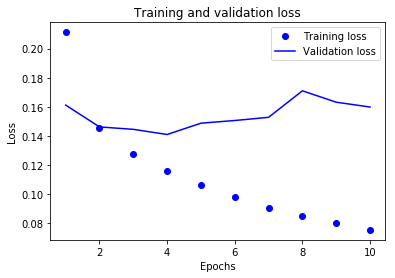

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

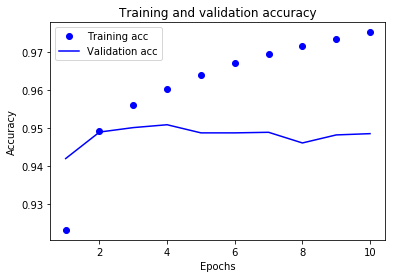

In [20]:
plt.clf()   # clear figure
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
'''https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/
In the case of a two-class (binary) classification problem, the sigmoid activation function is often used in the output layer. 
The predicted probability is taken as the likelihood of the observation belonging to class 1, or inverted (1 – probability) to give the probability for class 0.
In the case of a multi-class classification problem, the softmax activation function 
is often used on the output layer and the likelihood of the observation for each class is returned as a vector.
'''

y_prob = model.predict(x_val, verbose=1)
y_classes = y_prob.argmax(axis=-1)
y_classes_prob=[s.max() for s in y_prob]
y_classes_val=y_val.argmax(axis=-1)

df_val=pd.DataFrame({'pred':y_classes, 
                     'true':y_classes_val, 
                     'prob':y_classes_prob})
len(df_val[df_val.pred==df_val.true])/len(df_val)

36000/36000 [==============================] - 51s 1ms/step


0.7514166666666666

In [25]:
'''https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/
In the case of a two-class (binary) classification problem, the sigmoid activation function is often used in the output layer. 
The predicted probability is taken as the likelihood of the observation belonging to class 1, or inverted (1 – probability) to give the probability for class 0.
In the case of a multi-class classification problem, the softmax activation function 
is often used on the output layer and the likelihood of the observation for each class is returned as a vector.
'''

y_prob = model.predict(x_val, verbose=1)
y_classes = y_prob.argmax(axis=-1)
y_classes_prob=[s.max() for s in y_prob]
y_classes_val=y_val.argmax(axis=-1)

df_val=pd.DataFrame({'pred':y_classes, 
                     'true':y_classes_val, 
                     'prob':y_classes_prob})
len(df_val[df_val.pred==df_val.true])/len(df_val)

120000/120000 [==============================] - 118s 980us/step


0.8065

In [22]:
df_95=df_val[df_val.prob>.95]
print(len(df_95[df_95.pred==df_95.true])/len(df_95), len(df_95)/len(df_val))

0.9097281678082192 0.5191111111111111


In [27]:
df_val.sample(10)

,pred,true,prob
6838,3,5,0.739892
16717,1,1,0.981657
9961,3,3,0.988655
15989,0,1,0.500976
34186,5,5,0.821712
26873,1,1,0.976101
33774,1,1,0.981773
25580,7,7,0.836229
18159,1,7,0.980795
21771,3,3,0.995547


In [37]:
df_val.groupby('pred')[['prob']].describe()

prob                                                              \
        count      mean       std       min       25%       50%       75%   
pred                                                                        
0     14574.0  0.947898  0.140834  0.181094  0.994786  0.997717  0.998336   
1     20047.0  0.938727  0.150843  0.199948  0.982048  0.996910  0.998982   
2      6813.0  0.937554  0.145990  0.230144  0.983532  0.995575  0.997143   
3     13946.0  0.919894  0.163432  0.202485  0.950082  0.994085  0.997833   
4      4788.0  0.915918  0.158874  0.223830  0.934571  0.991566  0.997457   
5     34993.0  0.951979  0.125865  0.173467  0.987138  0.997629  0.998319   
6      2456.0  0.769482  0.228869  0.182271  0.593661  0.862013  0.967078   
7     18602.0  0.923707  0.159183  0.198981  0.957083  0.996431  0.998265   
8      3781.0  0.864114  0.213472  0.189253  0.806864  0.985537  0.997941   

                
           max  
pred            
0     0.999913  
1     0.999559  
2     0.999125  
3     0.999361  
4     0.999467  
5     0.999602  
6     0.996433  
7     0.999453  
8     0.999207

In [28]:
df_val.groupby('pred')[['prob']].describe()

prob                                                              \
        count      mean       std       min       25%       50%       75%   
pred                                                                        
0      3878.0  0.893846  0.169222  0.200335  0.890413  0.978879  0.989682   
1      5504.0  0.870570  0.164746  0.188946  0.826522  0.955931  0.977011   
2      1998.0  0.871377  0.178440  0.190420  0.817443  0.967236  0.989169   
3      4295.0  0.879368  0.177278  0.184492  0.840099  0.973080  0.992297   
4      1517.0  0.836238  0.184050  0.189743  0.744091  0.923662  0.979553   
5     10663.0  0.871253  0.171818  0.206576  0.822933  0.959143  0.986311   
6       343.0  0.457318  0.129805  0.175460  0.357263  0.448693  0.557864   
7      6602.0  0.823981  0.209800  0.192370  0.682801  0.936526  0.990312   
8      1200.0  0.692921  0.200447  0.202602  0.532967  0.748837  0.869758   

                
           max  
pred            
0     0.994728  
1     0.985090  
2     0.995268  
3     0.997352  
4     0.990551  
5     0.994159  
6     0.725925  
7     0.997062  
8     0.951971

In [208]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Dropout, LSTM
from keras.models import Model

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
'''
x = GRU(units=128, activation='tanh', return_sequences=True)(embedded_sequences)

x = LSTM(units=256, activation='tanh', return_sequences=False)(embedded_sequences)
x = Dropout(0.2)(x)

#x = LSTM(units=128, activation='tanh', return_sequences=True)(x)
#x = Dropout(0.2)(x)
'''
# x = Dropout(0.2)(x)
x = Flatten()(embedded_sequences)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='tanh')(x)
preds = Dense(units=9, activation='softmax')(x) #softmax

# x = Dense(units=512, activation='relu')(x)
# x = Dense(units=128, activation='relu')(x)
# preds = Dense(units=25, activation='sigmoid')(x) #softmax

model = Model(sequence_input, preds)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam', #'rmsprop',
              metrics=['acc',precision, recall])

history = model.fit(x_train, y_train, validation_split=0.8,
#                     validation_data=(x_val, y_val),
                    epochs=2, batch_size=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 200)         6692600   
_________________________________________________________________
flatten_13 (Flatten)         (None, 200000)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               102400512 
_________________________________________________________________
dense_39 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_40 (Dense)             (None, 9)                 1161      
Total params: 109,159,937
Trainable params: 102,467,337
Non-trainable params: 6,692,600
______________________________________________________

In [79]:
score = model.evaluate(x_val, y_val, batch_size=500, verbose=1)
score

60000/60000 [==============================] - 25s 412us/step


[0.19112927243113517, 0.9295742606123288, 0.1111111119389534, 1.0]

In [34]:
len(df_val[df_val.pred==df_val.true])

37694

In [38]:
df_95.pred.unique()

array([1, 0, 7, 5, 3, 4, 2])